In [4]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, CountVectorizer, StopWordsRemover, HashingTF, IDF, ChiSqSelector, CountVectorizer
from pyspark.ml.feature import Tokenizer, Normalizer, StringIndexer
from pyspark.sql.functions import col, lower

from pyspark.ml import Pipeline
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

from pyspark.mllib.util import MLUtils

import time

In [5]:
partial_dataset = "/user/dic24_shared/amazon-reviews/full/reviews_devset.json"
full_dataset = "/user/dic24_shared/amazon-reviews/full/reviewscombined.json"


In [6]:
#Initialize Spark Session
spark = SparkSession.builder \
    .appName("Text_Classification") \
    .getOrCreate()

try:
    df = spark.read.json(partial_dataset).select("category", "reviewText")
    print("File read successfully.")
    df.printSchema()
    df.show(5)
    
except Exception as e:
    print(f"Error: {e}")

File read successfully.
root
 |-- category: string (nullable = true)
 |-- reviewText: string (nullable = true)

+--------------------+--------------------+
|            category|          reviewText|
+--------------------+--------------------+
|Patio_Lawn_and_Garde|This was a gift f...|
|Patio_Lawn_and_Garde|This is a very ni...|
|Patio_Lawn_and_Garde|The metal base wi...|
|Patio_Lawn_and_Garde|For the most part...|
|Patio_Lawn_and_Garde|This hose is supp...|
+--------------------+--------------------+
only showing top 5 rows



# Part 1: RDDs

# Part 2: 

In [7]:
# Casefolding
df = df.withColumn("reviewText", lower(col("reviewText")))

In [8]:
# Сonverting category to numeric
indexer = StringIndexer(inputCol="category", outputCol="categoryIndex")

# Creating the pipeline:

# 1. tokenization
tokenizer = RegexTokenizer(inputCol="reviewText", outputCol="words", pattern=r'\s+|\t+|\d+|[(){}.!?,;:+=-_"\`~#@&*%€$§\\/]+', gaps=True)

# 2. Stopwords removal
stopwords_remover = StopWordsRemover(inputCol=tokenizer.getOutputCol(), outputCol="filtered_words")

# 3. tf-idf calculation with CountVectorizer
hashingTF = CountVectorizer(inputCol=stopwords_remover.getOutputCol(), outputCol="rawFeatures")
idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="features")

# # 4. TF-IDF calculation with HashingTF
# hashingTF = HashingTF(inputCol=stopwords_remover.getOutputCol(), outputCol="rawFeatures", numFeatures=20)
# idf = IDF(inputCol="rawFeatures", outputCol="features")

# 4. Chi-square
selector = ChiSqSelector(numTopFeatures=20, featuresCol=idf.getOutputCol(),
                         outputCol="selectedFeatures", labelCol=indexer.getOutputCol())


# pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, hashingTF, idf, selector])


# start_time = time.time()
# model = pipeline.fit(df)
# fit_time = time.time() - start_time
# print(f'fit_time={fit_time}')

# # Transform the test data
# result = model.transform(df)
# transform_time = time.time() - fit_time - start_time
# print(f'transform_time={transform_time}')

# # Extract the CountVectorizer model from the pipeline
# count_vectorizer_model = model.stages[3]
# vocab = count_vectorizer_model.vocabulary

# # Get the selected feature indices
# selected_indices = result.select("selectedFeatures").rdd.flatMap(lambda x: x).collect()

# # Convert the indices to terms
# selected_terms = [vocab[index] for indices in selected_indices for index in indices.indices]

    
# with open("output_ds.txt", "w") as f:
#     for term in selected_terms:
#         # print(term)
#         f.write(f"{term} ")


# Part 3:

In [9]:
# 6. Normalizing
normalizer = Normalizer(inputCol=selector.getOutputCol(), outputCol="normFeatures")

# 7. Creating SVM classificator
svm = LinearSVC(featuresCol=normalizer.getOutputCol(), labelCol="categoryIndex")

# 8. Using One-vs-Rest for multiclass classification
ovr = OneVsRest(classifier=svm, labelCol="categoryIndex")


# pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, hashingTF, idf, selector, normalizer, ovr])


In [10]:
# Splitting the data
train_df, validation_df, test_df,  = df.randomSplit([0.7, 0.15, 0.15], seed=42)

# train_df = train_df.sample(0.01)
# validation_df = train_df.sample(0.05)
# test_df = train_df.sample(0.05)

# Show the count of each set
print("Training set count:", train_df.count())
print("Test set count:", test_df.count())
print("Validation set count:", validation_df.count())

Training set count: 55401
Test set count: 11807
Validation set count: 11621


In [11]:
# # Creating a grid of parameters
# paramGrid = (ParamGridBuilder()
#              .addGrid(selector.numTopFeatures, [2000, 500])  # number of features selected
#              .addGrid(svm.regParam, [0.01, 0.1, 1.0])  # Regularization parameter
#              .addGrid(svm.maxIter, [10, 50])  # Maximum number of iterations
#              .addGrid(svm.standardization, [True, False]) # Standardization
#              .build())


# # Creating a Cross Validator for Grid search
# crossval = CrossValidator(estimator=pipeline,
#                           estimatorParamMaps=paramGrid,
#                           evaluator=MulticlassClassificationEvaluator(labelCol="categoryIndex", metricName="f1"),
#                           numFolds=3)

# # Model training
# try:
#     print("Starting model training...")
#     model = crossval.fit(train_df)
#     print("Model training completed.")
# except Exception as e:
#     print(f"Error during model training: {e}")


# # Predictions on the test data
# try:
#     print("Making predictions...")
#     predictions = model.transform(test_df)
#     print("Predictions made.")
# except Exception as e:
#     print(f"Error during predictions: {e}")


# # Evaluating the model
# try:
#     print("Evaluating the model...")
#     evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="f1")
#     f1_score = evaluator.evaluate(predictions)
#     print(f"F1 Score: {f1_score}")
# except Exception as e:
#     print(f"Error during evaluation: {e}")


# # Stopping Spark
# print("Stopping Spark...")
# spark.stop()
# print("Spark stopped.")

In [12]:
# # # Create pipeline
# # pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, hashingTF, idf, selector, normalizer, ovr])

# # # Create parameter grid
# # paramGrid = (ParamGridBuilder()
# #              .addGrid(selector.numTopFeatures, [50, 2000])
# #              .addGrid(svm.regParam, [0.01, 0.1, 1.0])
# #              .addGrid(svm.maxIter, [10, 50])
# #              .addGrid(svm.standardization, [True, False])
# #              .build())

# # Define evaluator

# # Precompute stages up to IDF
# pre_pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, count_vectorizer, idf])

# # Fit pre_pipeline
# pre_model = pre_pipeline.fit(train_df)

# # Cache the precomputed results
# train_df = pre_model.transform(train_df).cache()
# test_df = pre_model.transform(test_df).cache()
# validation_df = pre_model.transform(validation_df).cache()



# evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="f1")

# best_model = None
# best_f1_score = float('-inf')
# best_params = None


# numTopFeatures = [500, 2000]
# regParams =  [0.01, 0.1, 1.0]
# maxIters = [10, 50]
# standardizations = [True, False]

# # Iterate over the parameter grid
# for numTopFeature in numTopFeatures:
#     for regParam in regParams:
#         for maxIter in maxIters:
#             for standardization in standardizations:
#                 print(f'numTopFeature={numTopFeature}, regParam={regParam}, maxIter={maxIter}, standardization={standardization}')

#                 selector = ChiSqSelector(numTopFeatures=numTopFeature, featuresCol=idf.getOutputCol(),
#                                      outputCol="selectedFeatures", labelCol=indexer.getOutputCol())
#                 svm = LinearSVC(featuresCol=normalizer.getOutputCol(), labelCol="categoryIndex", regParam=regParam, maxIter=maxIter, standardization=standardization)

#                 pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, hashingTF, idf, selector, normalizer, ovr])

#                 # Create a new pipeline model with the current parameter combination
#                 start_time = time.time()
#                 print('fit')
#                 pipeline_model = pipeline.fit(train_df)
#                 fit_time = time.time() - start_time
#                 print(f'fit_time={fit_time}')

#                 print('transform')
#                 # Make predictions on the validation set
#                 predictions = pipeline_model.transform(validation_df)
#                 transform_time = time.time() - start_time  - fit_time
#                 print(f'transform_time={transform_time}')

#                 print('evaluate')
#                 # Evaluate the model
#                 f1_score = evaluator.evaluate(predictions)
#                 evaluate_time = time.time() - start_time  - fit_time - transform_time
#                 print(f'fit_time={evaluate_time}')

#                 print(f'f1_score={f1_score}')
                
#                 if f1_score > best_f1_score:
#                     best_f1_score = f1_score
#                     best_model = pipeline_model
#                     best_params = f'numTopFeature={numTopFeature}, regParam={regParam}, maxIter={maxIter}, standardization={standardization}'

# print(f"Best F1 Score: {best_f1_score}")
# print(f"Best Parameters: {best_params}")

# # Predictions on the test data
# try:
#     print("Making predictions...")
#     predictions = best_model.transform(test_df)
#     print("Predictions made.")
# except Exception as e:
#     print(f"Error during predictions: {e}")

# # Evaluating the model
# try:
#     print("Evaluating the model...")
#     f1_score = evaluator.evaluate(predictions)
#     print(f"F1 Score: {f1_score}")
# except Exception as e:
#     print(f"Error during evaluation: {e}")

# # Stopping Spark
# print("Stopping Spark...")
# spark.stop()
# print("Spark stopped.")

In [13]:
selector = ChiSqSelector(numTopFeatures=500, featuresCol=idf.getOutputCol(),
                         outputCol="selectedFeatures", labelCol=indexer.getOutputCol())

pre_pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, hashingTF, idf, selector])
# Fit pre_pipeline
pre_model = pre_pipeline.fit(train_df)

# Cache the precomputed results
preprocessed_train_df_500 = pre_model.transform(train_df).cache()
preprocessed_test_df_500 = pre_model.transform(test_df).cache()
preprocessed_validation_df_500 = pre_model.transform(validation_df).cache()


In [14]:
selector = ChiSqSelector(numTopFeatures=2000, featuresCol=idf.getOutputCol(),
                         outputCol="selectedFeatures", labelCol=indexer.getOutputCol())

pre_pipeline = Pipeline(stages=[indexer, tokenizer, stopwords_remover, hashingTF, idf, selector])
# Fit pre_pipeline
pre_model = pre_pipeline.fit(train_df)

# Cache the precomputed results
preprocessed_train_df_2000 = pre_model.transform(train_df).cache()
preprocessed_test_df_2000 = pre_model.transform(test_df).cache()
preprocessed_validation_df_2000 = pre_model.transform(validation_df).cache()


In [15]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, ChiSqSelector, StringIndexer, Normalizer
from pyspark.ml.classification import LinearSVC, OneVsRest
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
import time
from pyspark.sql.functions import col

In [16]:
# Create parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(LinearSVC.regParam, [0.01, 0.1, 1.0]) \
    .addGrid(LinearSVC.maxIter, [10, 50]) \
    .addGrid(LinearSVC.standardization, [True, False]) \
    .build()

evaluator = MulticlassClassificationEvaluator(labelCol="categoryIndex", predictionCol="prediction", metricName="f1")

best_model = None
best_f1_score = float('-inf')
best_params = None


## Experiment 1
regParam = 0.01
maxIter = 10
standardization = True

In [17]:
train_df = preprocessed_train_df_500
validation_df = preprocessed_validation_df_500
test_df = preprocessed_test_df_500


regParam = 0.01
maxIter = 10
standardization = True

print(f'fregParam={regParam}, maxIter={maxIter}, standardization={standardization}')

normalizer = Normalizer(inputCol="selectedFeatures", outputCol="normFeatures")
svm = LinearSVC(featuresCol="normFeatures", labelCol="categoryIndex", regParam=regParam, maxIter=maxIter, standardization=standardization)
ovr = OneVsRest(classifier=svm, labelCol="categoryIndex")

pipeline = Pipeline(stages=[normalizer, ovr])

# Create a new pipeline model with the current parameter combination
start_time = time.time()
pipeline_model = pipeline.fit(train_df)
fit_time = time.time() - start_time
print(f'fit_time={fit_time}')

# Make predictions on the validation set
predictions = pipeline_model.transform(validation_df)
transform_time = time.time() - start_time - fit_time
print(f'transform_time={transform_time}')

# Evaluate the model
f1_score = evaluator.evaluate(predictions)
evaluate_time = time.time() - start_time - fit_time - transform_time
print(f'evaluate_time={evaluate_time}')

print(f'f1_score={f1_score}')

if f1_score > best_f1_score:
    best_f1_score = f1_score
    best_model = pipeline_model
    best_params = f'regParam={regParam}, maxIter={maxIter}, standardization={standardization}'


fregParam=0.01, maxIter=10, standardization=True
fit_time=136.1888542175293
transform_time=5.932336807250977
evaluate_time=22.03845977783203
f1_score=0.648560079586016


In [18]:
best_model

PipelineModel_00951d8117df

In [23]:
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import pandas as pd

# Make predictions on the test set using the best model
test_predictions = best_model.transform(test_df)

# Select the relevant columns (true labels and predictions)
predictions_and_labels = test_predictions.select("categoryIndex", "prediction")

# Convert to RDD for evaluation
predictions_and_labels_rdd = predictions_and_labels.rdd.map(lambda row: (float(row["prediction"]), float(row["categoryIndex"])))

# Compute the confusion matrix
metrics = MulticlassMetrics(predictions_and_labels_rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Convert the confusion matrix to a pandas DataFrame
labels = test_predictions.select("categoryIndex").distinct().orderBy("categoryIndex").rdd.map(lambda r: r[0]).collect()
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

confusion_matrix_df

plt.imshow(confusion_matrix_df cmap='hot', interpolation='nearest')
plt.show()

/usr/lib/spark/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,...,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
0.0,3020.0,16.0,17.0,65.0,20.0,22.0,5.0,14.0,72.0,14.0,...,5.0,5.0,5.0,10.0,12.0,8.0,10.0,5.0,7.0,4.0
1.0,73.0,813.0,35.0,17.0,14.0,11.0,93.0,16.0,6.0,18.0,...,4.0,17.0,13.0,2.0,0.0,12.0,1.0,3.0,0.0,2.0
2.0,42.0,16.0,679.0,4.0,16.0,5.0,1.0,26.0,4.0,12.0,...,10.0,2.0,1.0,1.0,3.0,3.0,2.0,1.0,0.0,0.0
3.0,129.0,16.0,6.0,529.0,1.0,23.0,1.0,6.0,9.0,5.0,...,0.0,0.0,2.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0
4.0,44.0,28.0,29.0,7.0,390.0,6.0,4.0,21.0,2.0,15.0,...,6.0,16.0,3.0,7.0,2.0,6.0,7.0,4.0,0.0,0.0
5.0,32.0,6.0,2.0,32.0,5.0,444.0,2.0,1.0,5.0,0.0,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,9.0,4.0
6.0,28.0,100.0,18.0,2.0,14.0,3.0,303.0,11.0,2.0,6.0,...,4.0,5.0,1.0,0.0,1.0,4.0,0.0,2.0,0.0,0.0
7.0,48.0,34.0,88.0,9.0,25.0,4.0,11.0,193.0,4.0,15.0,...,7.0,19.0,8.0,3.0,2.0,4.0,4.0,6.0,1.0,2.0
8.0,455.0,7.0,4.0,9.0,3.0,5.0,6.0,2.0,11.0,1.0,...,0.0,0.0,1.0,0.0,3.0,0.0,0.0,0.0,1.0,0.0
9.0,59.0,24.0,26.0,6.0,37.0,4.0,7.0,21.0,1.0,184.0,...,30.0,5.0,2.0,16.0,7.0,4.0,2.0,0.0,1.0,0.0


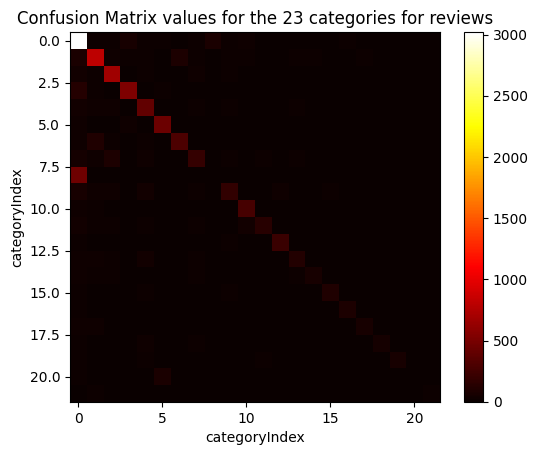

regParam=0.01, maxIter=10, standardization=True


<Figure size 640x480 with 0 Axes>

In [31]:
plt.imshow(confusion_matrix_df, cmap='hot', interpolation='nearest')
plt.title("Confusion Matrix values for the 23 categories for reviews")
plt.xlabel("prediction")
plt.ylabel("categoryIndex")
plt.colorbar()
plt.show()
print(best_params)
plt.savefig(f'confusion_matrix.png')

In [ ]:
# regParam, maxIter, standardization, numTopFeatures, fit_time, f1_score
# confusion_matrix or per_example qualitative analysis


## Experiment 2
regParam = 0.1
maxIter = 10
standardization = True

In [ ]:
train_df = preprocessed_train_df_500
validation_df = preprocessed_validation_df_500
test_df = preprocessed_test_df_500


regParam = 0.1
maxIter = 10
standardization = True

print(f'fregParam={regParam}, maxIter={maxIter}, standardization={standardization}')

normalizer = Normalizer(inputCol="selectedFeatures", outputCol="normFeatures")
svm = LinearSVC(featuresCol="normFeatures", labelCol="categoryIndex", regParam=regParam, maxIter=maxIter, standardization=standardization)
ovr = OneVsRest(classifier=svm, labelCol="categoryIndex")

pipeline = Pipeline(stages=[normalizer, ovr])

# Create a new pipeline model with the current parameter combination
start_time = time.time()
pipeline_model = pipeline.fit(train_df)
fit_time = time.time() - start_time
print(f'fit_time={fit_time}')

# Make predictions on the validation set
predictions = pipeline_model.transform(validation_df)
transform_time = time.time() - start_time - fit_time
print(f'transform_time={transform_time}')

# Evaluate the model
f1_score = evaluator.evaluate(predictions)
evaluate_time = time.time() - start_time - fit_time - transform_time
print(f'evaluate_time={evaluate_time}')

print(f'f1_score={f1_score}')

if f1_score > best_f1_score:
    best_f1_score2 = f1_score
    best_model2 = pipeline_model
    best_params2 = f'regParam={regParam}, maxIter={maxIter}, standardization={standardization}'
    
best_model2

fregParam=0.1, maxIter=10, standardization=True


In [ ]:
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import pandas as pd

# Make predictions on the test set using the best model
test_predictions = best_model.transform(test_df)

# Select the relevant columns (true labels and predictions)
predictions_and_labels = test_predictions.select("categoryIndex", "prediction")

# Convert to RDD for evaluation
predictions_and_labels_rdd = predictions_and_labels.rdd.map(lambda row: (float(row["prediction"]), float(row["categoryIndex"])))

# Compute the confusion matrix
metrics = MulticlassMetrics(predictions_and_labels_rdd)
confusion_matrix = metrics.confusionMatrix().toArray()

# Convert the confusion matrix to a pandas DataFrame
labels = test_predictions.select("categoryIndex").distinct().orderBy("categoryIndex").rdd.map(lambda r: r[0]).collect()
confusion_matrix_df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)

confusion_matrix_df

plt.imshow(confusion_matrix_df cmap='hot', interpolation='nearest')
plt.show()

In [ ]:
plt.imshow(confusion_matrix_df, cmap='hot', interpolation='nearest')
plt.title("Confusion Matrix values for the 23 categories for reviews")
plt.xlabel("prediction")
plt.ylabel("categoryIndex")
plt.colorbar()
plt.show()
print(best_params)
plt.savefig(f'confusion_matrix.png')

## Experiment 3
regParam = 0.1
maxIter = 10
standardization = False

regParam = 0.01 maxIter = 10 standardization = True <- done
regParam = 0.1 maxIter = 10 standardization = True <- running

regParam = 0.1 maxIter = 10 standardization = False <- to be run
regParam = 0.1 maxIter = 10 standardization = False < to be run


In [ ]:
train_df = preprocessed_train_df_500
validation_df = preprocessed_validation_df_500
test_df = preprocessed_test_df_500


# Iterate over the parameter grid
for params in paramGrid:
    regParam = params[LinearSVC.regParam]
    maxIter = params[LinearSVC.maxIter]
    standardization = params[LinearSVC.standardization]

    print(f'fregParam={regParam}, maxIter={maxIter}, standardization={standardization}')

    normalizer = Normalizer(inputCol="selectedFeatures", outputCol="normFeatures")
    svm = LinearSVC(featuresCol="normFeatures", labelCol="categoryIndex", regParam=regParam, maxIter=maxIter, standardization=standardization)
    ovr = OneVsRest(classifier=svm, labelCol="categoryIndex")

    pipeline = Pipeline(stages=[normalizer, ovr])

    # Create a new pipeline model with the current parameter combination
    start_time = time.time()
    pipeline_model = pipeline.fit(train_df)
    fit_time = time.time() - start_time
    print(f'fit_time={fit_time}')

    # Make predictions on the validation set
    predictions = pipeline_model.transform(validation_df)
    transform_time = time.time() - start_time - fit_time
    print(f'transform_time={transform_time}')

    # Evaluate the model
    f1_score = evaluator.evaluate(predictions)
    evaluate_time = time.time() - start_time - fit_time - transform_time
    print(f'evaluate_time={evaluate_time}')

    print(f'f1_score={f1_score}')

    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_model = pipeline_model
        best_params = f'regParam={regParam}, maxIter={maxIter}, standardization={standardization}'



In [ ]:
train_df = preprocessed_train_df_2000
validation_df = preprocessed_validation_df_2000
test_df = preprocessed_test_df_2000


# Iterate over the parameter grid
for params in paramGrid:
    regParam = params[LinearSVC.regParam]
    maxIter = params[LinearSVC.maxIter]
    standardization = params[LinearSVC.standardization]

    print(f'fregParam={regParam}, maxIter={maxIter}, standardization={standardization}')

    normalizer = Normalizer(inputCol="selectedFeatures", outputCol="normFeatures")
    svm = LinearSVC(featuresCol="normFeatures", labelCol="categoryIndex", regParam=regParam, maxIter=maxIter, standardization=standardization)
    ovr = OneVsRest(classifier=svm, labelCol="categoryIndex")

    pipeline = Pipeline(stages=[normalizer, ovr])

    # Create a new pipeline model with the current parameter combination
    start_time = time.time()
    pipeline_model = pipeline.fit(train_df)
    fit_time = time.time() - start_time
    print(f'fit_time={fit_time}')

    # Make predictions on the validation set
    predictions = pipeline_model.transform(validation_df)
    transform_time = time.time() - start_time - fit_time
    print(f'transform_time={transform_time}')

    # Evaluate the model
    f1_score = evaluator.evaluate(predictions)
    evaluate_time = time.time() - start_time - fit_time - transform_time
    print(f'evaluate_time={evaluate_time}')

    print(f'f1_score={f1_score}')

    if f1_score > best_f1_score:
        best_f1_score = f1_score
        best_model = pipeline_models
        best_params = f'regParam={regParam}, maxIter={maxIter}, standardization={standardization}'



In [ ]:
print(f"Best F1 Score: {best_f1_score}")
print(f"Best Parameters: {best_params}")

# Predictions on the test data
try:
    print("Making predictions...")
    predictions = best_model.transform(validation_df)
    print("Predictions made.")
except Exception as e:
    print(f"Error during predictions: {e}")

# Evaluating the model
try:
    print("Evaluating the model...")
    f1_score = evaluator.evaluate(predictions)
    print(f"F1 Score: {f1_score}")
except Exception as e:
    print(f"Error during evaluation: {e}")

# Stopping Spark
print("Stopping Spark...")
spark.stop()
print("Spark stopped.")